In [149]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm


Data type conversion

In [150]:
df = pd.read_csv('combined_file.csv')
pd.set_option('display.max_columns', None)

# extract only numbers
df['km'] = df['km'].astype(str)
df['km'] = df['km'].str.replace(",","")
df['km'] = pd.to_numeric(df['km'])

#price convert to int 
def convert_to_int(value):
    if pd.isna(value):
        return None  
    value = value.replace('₹', '').strip()

    if 'Lakh' in value:
        value = value.replace('Lakh', '').strip()
        multiplier = 1e5  
    elif 'Crore' in value:
        value = value.replace('Crore', '').strip()
        multiplier = 1e7 
    else:
        multiplier = 1  

    value = value.replace(',', '')

    try:
        return int(float(value) * multiplier)
    except ValueError:
        return None 


# Apply the function to the 'price' column
df['price'] = df['price'].apply(convert_to_int)

df['seating_capacity'] = df['seating_capacity'].fillna(0).astype(int)

df['wheel_base'] = df['wheel_base'].astype(str)
df['wheel_base'] = df['wheel_base'].str.extract(r'(\d+)')  
df['wheel_base'] = pd.to_numeric(df['wheel_base'])
df['wheel_base'] = df['wheel_base'].fillna(df['wheel_base'].mean()).astype(int)

df['gear_box'] = df['gear_box'].astype(str)
df['gear_box'] = df['gear_box'].str.extract(r'(\d+)')  
df['gear_box'] = pd.to_numeric(df['gear_box'])
df['gear_box'] = df['gear_box'].fillna(df['gear_box'].mean()).astype(int)

columns_to_keep = [
    'city','ft', 'bt', 'km', 'transmission', 'ownerno', 'model', 
    'modelyear','color','price'
]
#'top_features', 'color','insurance_validity','rto'
# Creating a new DataFrame with only the specified columns
df = df[columns_to_keep]

df = df

C:\Users\New\AppData\Local\Temp\ipykernel_12448\1123088344.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('combined_file.csv')


In [151]:
df.head(3)

,city,ft,bt,km,transmission,ownerno,model,modelyear,color,price
0,bangalore,Petrol,Hatchback,120000,Manual,3,Maruti Celerio,2015,White,400000
1,bangalore,Petrol,SUV,32706,Manual,2,Ford Ecosport,2018,White,811000
2,bangalore,Petrol,Hatchback,11949,Manual,1,Tata Tiago,2018,Red,585000


In [152]:
df.columns

Index(['city', 'ft', 'bt', 'km', 'transmission', 'ownerno', 'model',
       'modelyear', 'color', 'price'],
      dtype='object')

label encoding for ordinal categorical variables.

In [153]:
categorical_cols = df.select_dtypes(include=[object]).columns

le = LabelEncoder()
for column in categorical_cols:
    df[column] = le.fit_transform(df[column])

In [154]:
df.head(2)

,city,ft,bt,km,transmission,ownerno,model,modelyear,color,price
0,0,4,2,120000,1,3,160,2015,138,400000
1,0,4,7,32706,1,2,50,2018,138,811000


In [155]:
df.describe()

,city,ft,bt,km,transmission,ownerno,model,modelyear,color,price
count,8369.000000,8369.000000,8369.000000,8.369000e+03,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,8.369000e+03
mean,2.416418,2.986378,4.985303,5.897430e+04,0.723145,1.360139,143.654081,2016.503286,88.526706,9.569036e+05
std,1.703520,1.431784,2.707789,7.406100e+04,0.447471,0.641958,79.474560,3.921465,42.008572,1.416203e+06
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1985.000000,0.000000,2.016100e+04
25%,1.000000,1.000000,2.000000,3.000000e+04,0.000000,1.000000,77.000000,2014.000000,57.000000,3.990000e+05
50%,2.000000,4.000000,7.000000,5.369200e+04,1.000000,1.000000,148.000000,2017.000000,86.000000,6.010000e+05
75%,4.000000,4.000000,8.000000,8.000000e+04,1.000000,2.000000,184.000000,2019.000000,116.000000,9.500000e+05
max,5.000000,4.000000,10.000000,5.500000e+06,1.000000,5.000000,314.000000,2023.000000,153.000000,4.150000e+07


In [156]:
df.corr()

,city,ft,bt,km,transmission,ownerno,model,modelyear,color,price
city,1.000000,-0.014920,-0.004165,-0.020517,0.097957,-0.058144,-0.004007,-0.005974,-0.039561,-0.075789
ft,-0.014920,1.000000,-0.299905,-0.165490,0.077116,-0.044848,-0.040365,0.055197,0.001743,-0.181315
bt,-0.004165,-0.299905,1.000000,0.031117,-0.254958,-0.035453,-0.073185,0.097258,-0.031798,0.268728
km,-0.020517,-0.165490,0.031117,1.000000,0.065439,0.115419,0.023288,-0.245030,0.009066,-0.077351
transmission,0.097957,0.077116,-0.254958,0.065439,1.000000,0.046777,0.040397,-0.196946,0.039501,-0.422600
ownerno,-0.058144,-0.044848,-0.035453,0.115419,0.046777,1.000000,-0.030762,-0.390012,0.026603,-0.120489
model,-0.004007,-0.040365,-0.073185,0.023288,0.040397,-0.030762,1.000000,0.074859,-0.000241,-0.007771
modelyear,-0.005974,0.055197,0.097258,-0.245030,-0.196946,-0.390012,0.074859,1.000000,-0.027913,0.299459
color,-0.039561,0.001743,-0.031798,0.009066,0.039501,0.026603,-0.000241,-0.027913,1.000000,-0.047611
price,-0.075789,-0.181315,0.268728,-0.077351,-0.422600,-0.120489,-0.007771,0.299459,-0.047611,1.000000


Heatmap

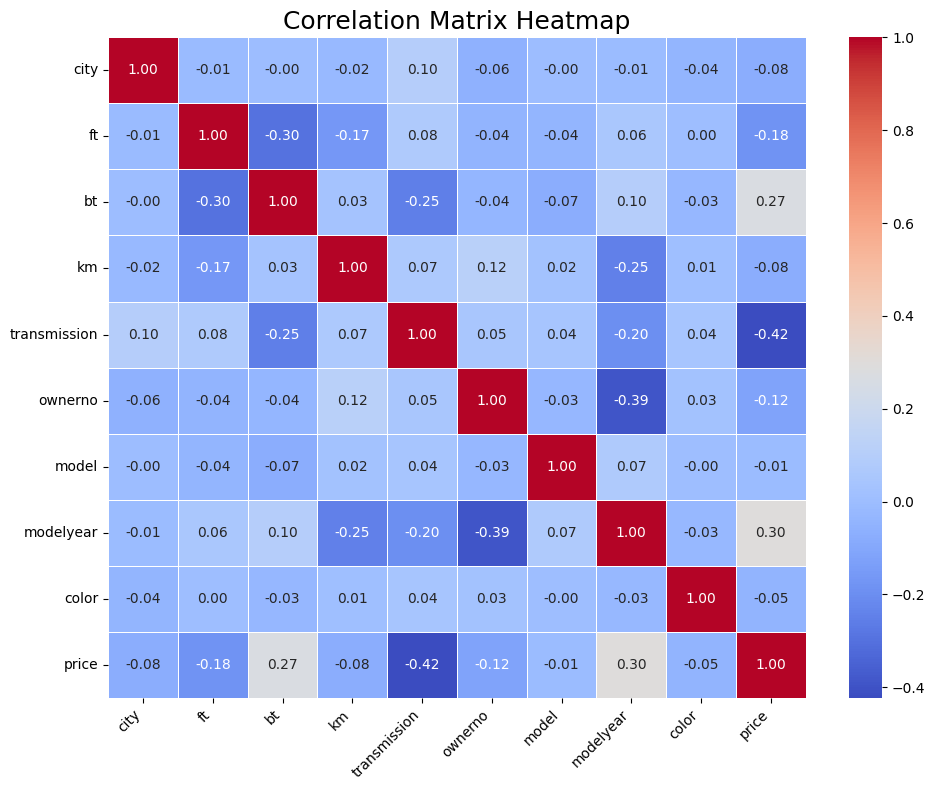

In [157]:
correlation_matrix = df.corr()

# Set the size of the plot
plt.figure(figsize=(10, 8))

# Create the heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Customize the heatmap
plt.title('Correlation Matrix Heatmap', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()


box plot

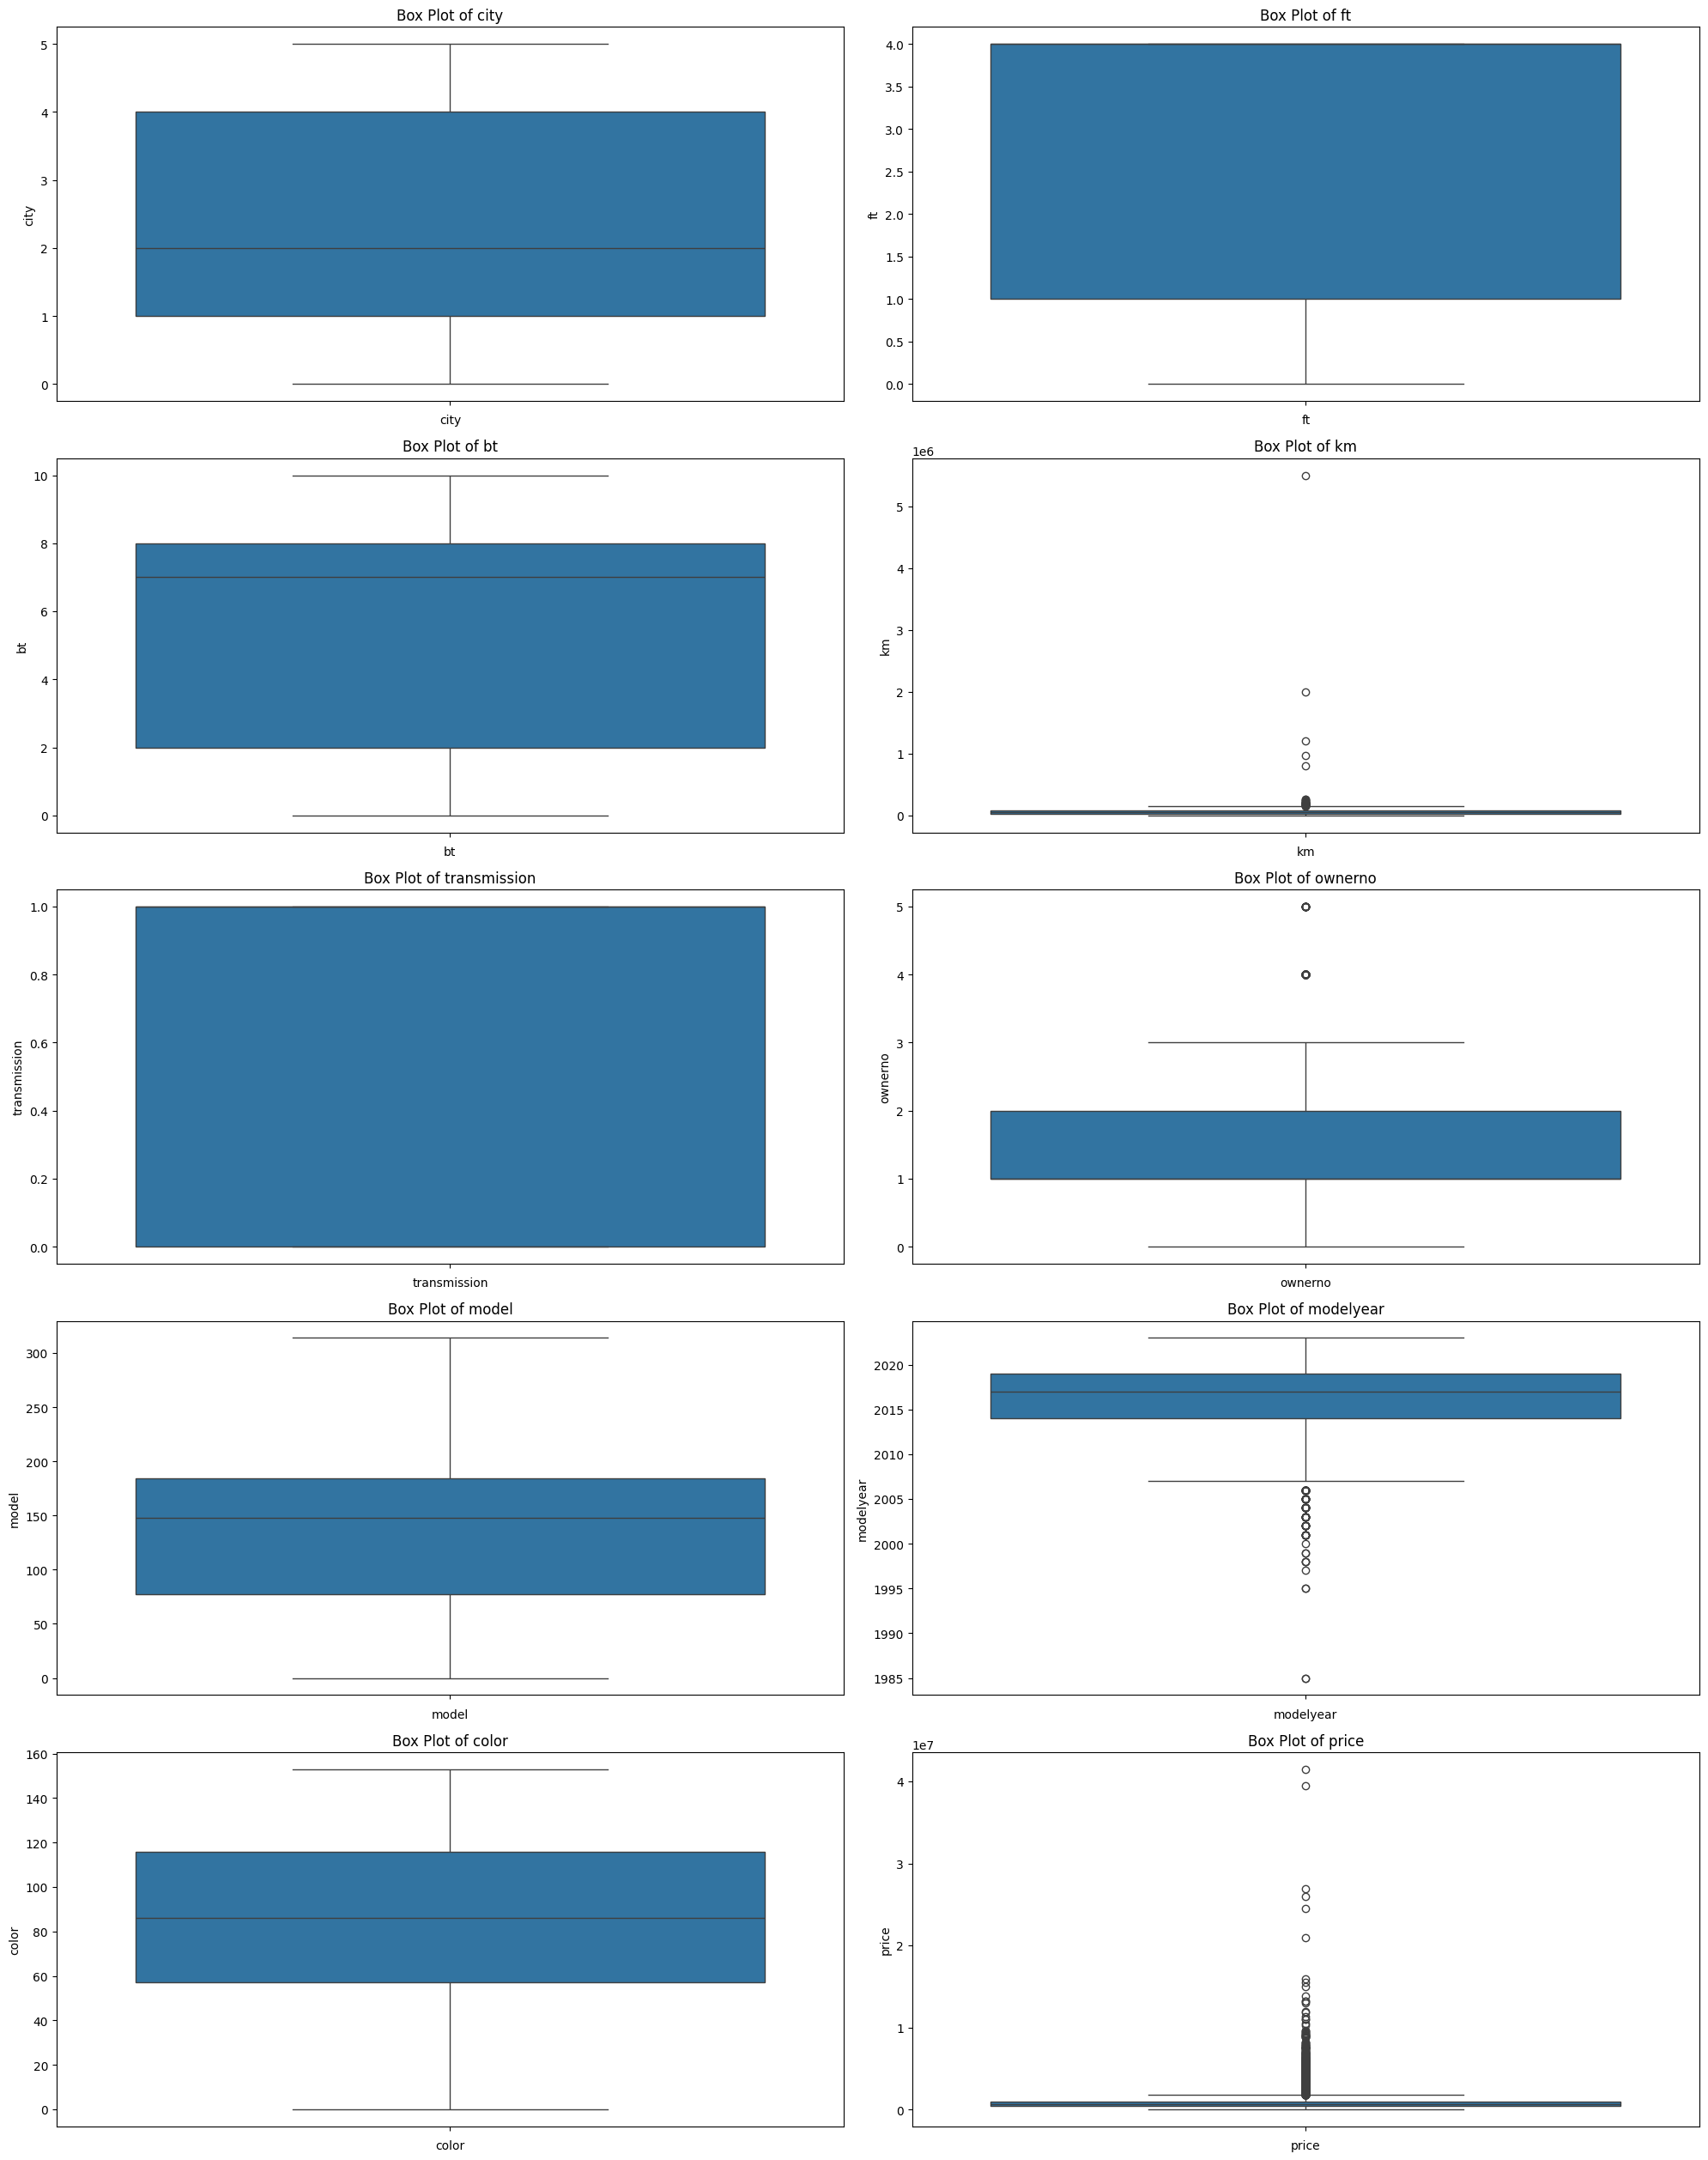

In [158]:
numerical_columns = df.columns

# Set the size of the overall figure
plt.figure(figsize=(20, 30))

# Loop through each numerical column and plot the box plot
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns) // 2 + 1, 2, i)
    sns.boxplot(data=df[col])
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    plt.tight_layout()  # Adjust the layout to prevent overlap

# Show the plots
plt.show()


Hist Plot

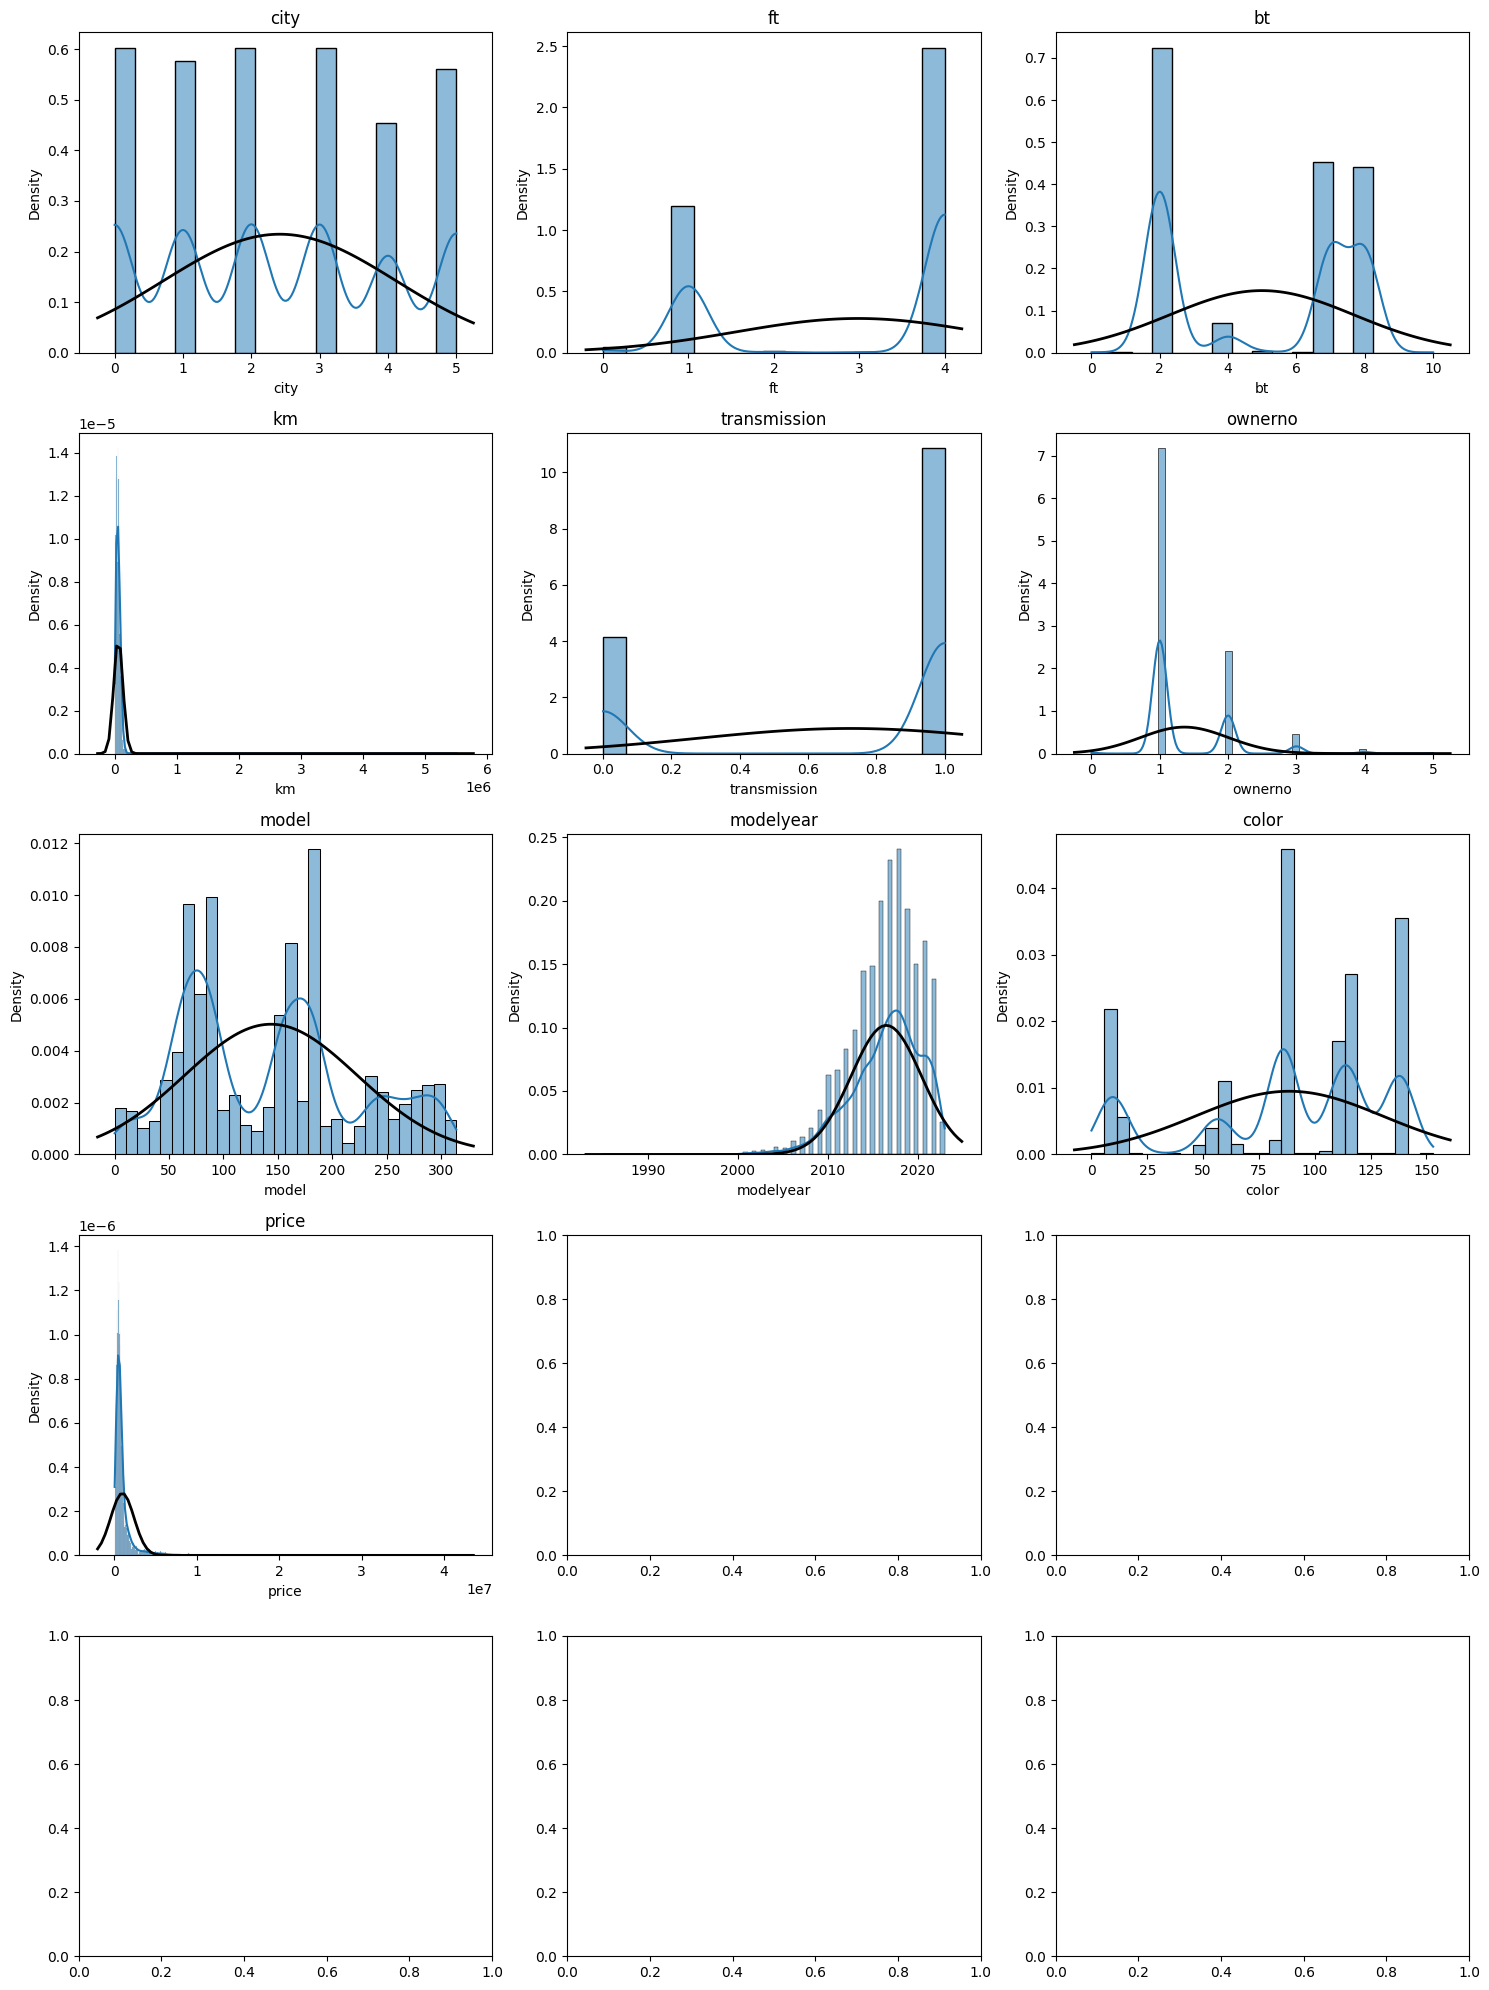

In [159]:
data = df
# Plot histograms with normal distribution fit
columns = data.columns
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20))

for i, column in enumerate(columns):
    sns.histplot(data[column], kde=True, ax=axes[i//3, i%3], stat="density")
    mu, std = norm.fit(data[column])
    xmin, xmax = axes[i//3, i%3].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    axes[i//3, i%3].plot(x, p, 'k', linewidth=2)
    axes[i//3, i%3].set_title(f'{column}')
    axes[i//3, i%3].set_ylabel('Density')

plt.tight_layout()
plt.show()


Outliers

In [160]:
columns = df.columns

# Create a mask to filter out outliers
mask = pd.Series([True] * len(df))

for column in columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Update mask to identify non-outlier rows
    column_mask = (df[column] >= lower_bound) & (df[column] <= upper_bound)
    mask = mask & column_mask

# Filter the DataFrame to remove outliers
cleaned_df = df[mask].reset_index(drop=True)


In [167]:
cleaned_df.shape

(7238, 10)

linear model without outlier deduction

In [161]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

X_train,X_test,y_train,y_test =train_test_split(X,y,random_state=42,test_size=0.2)

model = LinearRegression()
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

def evaluation():
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Mean Absolute Error:", mae)
    print("Mean Squared Error:", mse)
    print("R-squared:", r2)

linear model with outlier deduction

In [162]:
X = cleaned_df.iloc[:,:-1].values
y = cleaned_df.iloc[:,-1].values

X_train,X_test,y_train,y_test =train_test_split(X,y,random_state=42,test_size=0.2)

model = LinearRegression()
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

evaluation()

Mean Absolute Error: 171717.17458078612
Mean Squared Error: 53092423928.760826
R-squared: 0.5890792165841736


PCA

In [163]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=9)  # Specify number of components
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train_pca, y_train)

# Make predictions
y_pred = model.predict(X_test_pca)

evaluation()

Mean Absolute Error: 171717.17458078745
Mean Squared Error: 53092423928.76119
R-squared: 0.5890792165841708


feature_importance

In [164]:
def feature_importance():
    feature_importances = model.feature_importances_
    feature_names = cleaned_df.columns[:-1]

    # Create a DataFrame to view feature importance
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print("\nFeature Importance:")
    print(importance_df)

    # Plotting feature importance
    importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False, figsize=(10, 6))
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance in Random Forest')
    plt.gca().invert_yaxis()  # To display the most important features at the top
    plt.show()


RandomForestRegressor

Mean Absolute Error: 77830.10456001986
Mean Squared Error: 14387870439.838385
R-squared: 0.8886418333290478

Feature Importance:
        Feature  Importance
2            bt    0.299531
7     modelyear    0.288446
6         model    0.196934
4  transmission    0.074014
3            km    0.046739
0          city    0.039527
1            ft    0.025113
8         color    0.022766
5       ownerno    0.006929


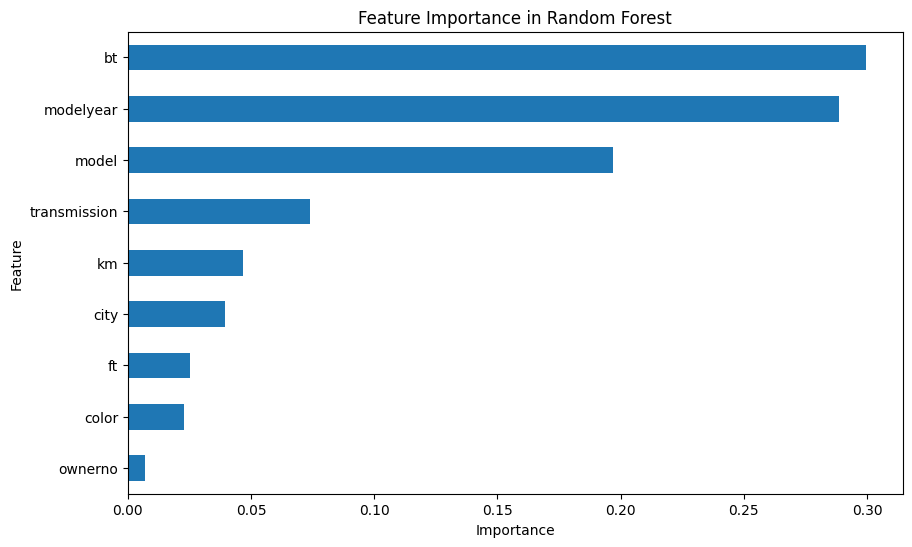

In [165]:
# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=200)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
evaluation()
# Get feature importance
feature_importance()

hyper parameter tunning gridsearch

c:\Users\New\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\New\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\New\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\New\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", lin

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean Absolute Error: 91964.03044516245
Mean Squared Error: 18903219637.259163
R-squared: 0.8536942703379551

Feature Importance:
        Feature  Importance
2            bt    0.299531
7     modelyear    0.288446
6         model    0.196934
4  transmission    0.074014
3            km    0.046739
0          city    0.039527
1            ft    0.025113
8         color    0.022766
5       ownerno    0.006929


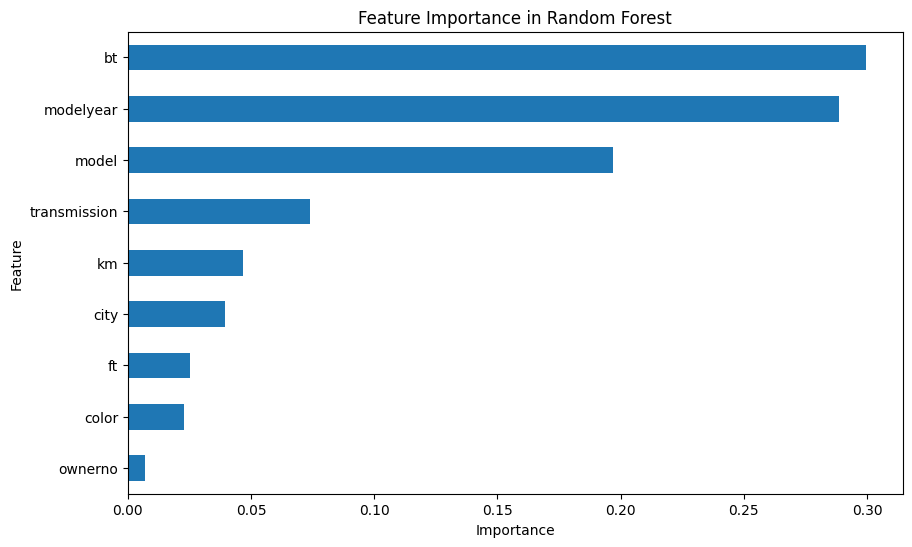

In [166]:
rf_model = RandomForestRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on test set (if you have a separate test set)
y_pred = best_rf_model.predict(X_test)

evaluation()

feature_importance()
